# _(Bouchacourt & Buschman, 2019)_ Flexible Working Memory Model

Implementation of :

- Bouchacourt, Flora, and Timothy J. Buschman. "A flexible model of working memory." Neuron 103.1 (2019): 147-160.

Author:

- Chaoming Wang (chao.brain@qq.com)

In [1]:
import matplotlib.pyplot as plt

In [2]:
import brainpy as bp
import brainpy.math as bm

In [3]:
# increase in order to run multiple trials with the same network
num_trials = 1
num_item_to_load = 6

In [4]:
# Parameters for network architecture
# ------------------------------------

num_sensory_neuron = 512  # Number of recurrent neurons per sensory network
num_sensory_pool = 8  # Number of ring-like sensory network
num_all_sensory = num_sensory_pool * num_sensory_neuron
num_all_random = 1024  # Number of neuron in the random network
fI_slope = 0.4  # slope of the non-linear f-I function
bias = 0.  # bias in the neuron firing response (cf page 1 right column of Burak, Fiete 2012)
tau = 10.  # Synaptic time constant [ms]
init_range = 0.01  # Range to randomly initialize synaptic variables

In [5]:
# Parameters for sensory network
# -------------------------------

k2 = 0.25  # width of negative surround suppression
k1 = 1.  # width of positive amplification
A = 2.  # amplitude of weight function
lambda_ = 0.28  # baseline of weight matrix for recurrent network

In [6]:
# Parameters for interaction of
# random network <-> sensory network
# -----------------------------------

forward_balance = -1.  # if -1, perfect feed-forward balance from SN to RN
backward_balance = -1.  # if -1, perfect feedback balance from RN to SN
alpha = 2.1  # parameter used to compute the feedforward weight, before balancing
beta = 0.2  # parameter used to compute the feedback weight, before balancing
gamma = 0.35  # connectivity (gamma in the paper)
factor = 1000  # factor for computing weights values

In [7]:
# Parameters for stimulus
# -----------------------

simulation_time = 1100  # # the simulation time [ms]
start_stimulation = 100  # [ms]
end_stimulation = 200  # [ms]
input_strength = 10  # strength of the stimulation
num_sensory_input_width = 32
# the width for input stimulation of the gaussian distribution
sigma = round(num_sensory_neuron / num_sensory_input_width)
three_sigma = 3 * sigma
activity_threshold = 3

In [8]:
# Weights initialization
# ----------------------

# weight matrix within sensory network
sensory_encoding = 2. * bm.pi * bm.arange(1, num_sensory_neuron + 1) / num_sensory_neuron
diff = sensory_encoding.reshape((-1, 1)) - sensory_encoding
weight_mat_of_sensory = lambda_ + A * bm.exp(k1 * (bm.cos(diff) - 1)) - A * bm.exp(k2 * (bm.cos(diff) - 1))
diag = bm.arange(num_sensory_neuron)
weight_mat_of_sensory[diag, diag] = 0.

In [9]:
# connectivity matrix between sensory and random network
conn_matrix_sensory2random = bm.random.rand(num_all_sensory, num_all_random) < gamma

In [10]:
# weight matrix of sensory2random
ws = factor * alpha / conn_matrix_sensory2random.sum(axis=0)
weight_mat_sensory2random = conn_matrix_sensory2random * ws.reshape((1, -1))
ws = weight_mat_sensory2random.sum(axis=0).reshape((1, -1))
weight_mat_sensory2random += forward_balance / num_all_sensory * ws  # balance

In [11]:
# weight matrix of random2sensory
ws = factor * beta / conn_matrix_sensory2random.sum(axis=1)
weight_mat_random2sensory = conn_matrix_sensory2random.T * ws.reshape((1, -1))
ws = weight_mat_random2sensory.sum(axis=0).reshape((1, -1))
weight_mat_random2sensory += backward_balance / num_all_random * ws  # balance

In [12]:
@bm.jit
def f(inp_ids, center):
  inp_scale = bm.exp(-(inp_ids - center) ** 2 / 2 / sigma ** 2) / (bm.sqrt(2 * bm.pi) * sigma)
  inp_scale /= bm.max(inp_scale)
  inp_ids = bm.remainder(inp_ids - 1, num_sensory_neuron)
  input = bm.zeros(num_sensory_neuron)
  input[inp_ids] = input_strength * inp_scale
  input -= bm.sum(input) / num_sensory_neuron
  return input


def get_input(center):
  inp_ids = bm.arange(bm.asarray(center - three_sigma, dtype=bm.int32),
                      bm.asarray(center + three_sigma + 1, dtype=bm.int32),
                      1)
  return f(inp_ids, center)

In [13]:
def get_activity_vector(rates):
  exp_stim_encoding = bm.exp(1j * sensory_encoding)
  timed_abs = bm.zeros(num_sensory_pool)
  timed_angle = bm.zeros(num_sensory_pool)
  for si in range(num_sensory_pool):
    start = si * num_sensory_neuron
    end = (si + 1) * num_sensory_neuron
    exp_rates = bm.multiply(rates[start:end], exp_stim_encoding)
    mean_rates = bm.mean(exp_rates)
    timed_angle[si] = bm.angle(mean_rates) * num_sensory_neuron / (2 * bm.pi)
    timed_abs[si] = bm.absolute(mean_rates)
  timed_angle[timed_angle < 0] += num_sensory_neuron
  return timed_abs, timed_angle

In [14]:
class PoissonNeuron(bp.NeuGroup):
  def __init__(self, size, **kwargs):
    super(PoissonNeuron, self).__init__(size=size, **kwargs)

    self.s = bm.Variable(bm.zeros(self.num))
    self.r = bm.Variable(bm.zeros(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.rng = bm.random.RandomState()

    self.int_s = bp.odeint(lambda s, t: -s / tau, method='exp_euler')

  def update(self, tdi):
    self.s.value = self.int_s(self.s, tdi.t, tdi.dt)
    self.r.value = 0.4 * (1. + bm.tanh(fI_slope * (self.input + self.s + bias) - 3.)) / tau
    self.spike.value = self.rng.random(self.s.shape) < self.r * tdi.dt
    self.input[:] = 0.

  def reset_state(self, batch_size=None):
    self.s.value = self.rng.random(self.num) * init_range
    self.r.value = 0.4 * (1. + bm.tanh(fI_slope * (bias + self.s) - 3.)) / tau
    self.input.value = bm.zeros(self.num)
    self.spike.value = bm.zeros(self.num, dtype=bool)

In [15]:
class Sen2SenSyn(bp.SynConn):
  def __init__(self, pre, post, **kwargs):
    super(Sen2SenSyn, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, tdi):
    for i in range(num_sensory_pool):
      start = i * num_sensory_neuron
      end = (i + 1) * num_sensory_neuron
      self.post.s[start: end] += bm.dot(self.pre.spike[start: end],
                                        weight_mat_of_sensory)

In [16]:
class OtherSyn(bp.SynConn):
  def __init__(self, pre, post, weights, **kwargs):
    super(OtherSyn, self).__init__(pre=pre, post=post, **kwargs)
    self.weights = weights

  def update(self, tdi):
    self.post.s += bm.dot(self.pre.spike, self.weights)

In [17]:
class Network(bp.Network):
  def __init__(self):
    super(Network, self).__init__()

    self.sensory = PoissonNeuron(num_all_sensory)
    self.random = PoissonNeuron(num_all_random)
    self.sensory2sensory = Sen2SenSyn(pre=self.sensory, post=self.sensory)
    self.random2sensory = OtherSyn(pre=self.random,
                                   post=self.sensory,
                                   weights=weight_mat_random2sensory)
    self.sensory2random = OtherSyn(pre=self.sensory,
                                   post=self.random,
                                   weights=weight_mat_sensory2random)

Load 6 items in trial 0.



  0%|          | 0/11000 [00:00<?, ?it/s]

Stimulus is given in: [0 1 2 4 5 7]
Memory is found in: [0 7]
2 maintained memories
4 forgotten memories
0 spurious memories



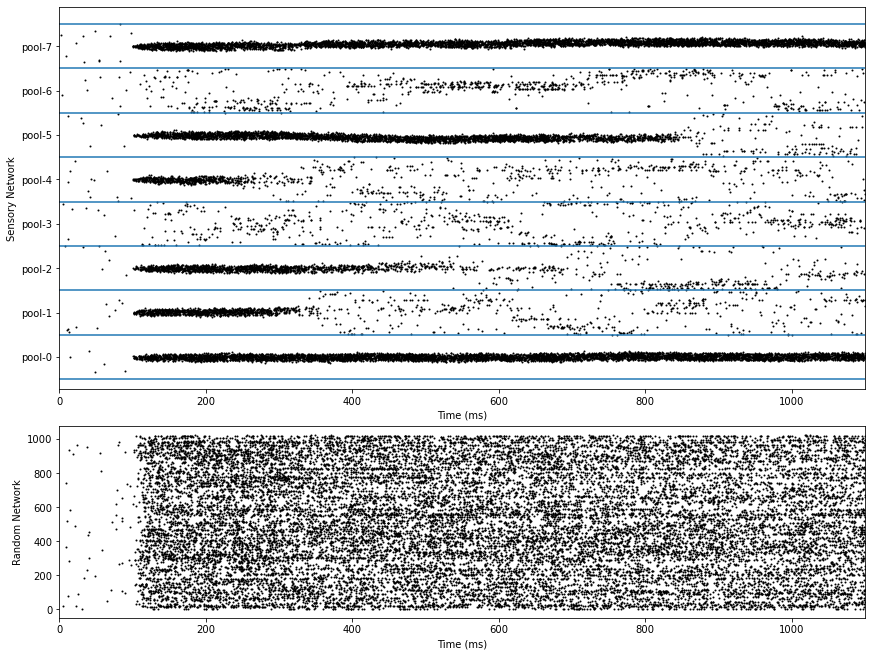

In [18]:
for trial_idx in range(num_trials):
  # inputs
  # ------
  pools_receiving_inputs = bm.random.choice(num_sensory_pool, num_item_to_load, replace=False)
  print(f"Load {num_item_to_load} items in trial {trial_idx}.\n")

  input_center = bm.ones(num_sensory_pool) * num_sensory_neuron / 2
  inp_vector = bm.zeros((num_sensory_pool, num_sensory_neuron))
  for si in pools_receiving_inputs:
    inp_vector[si, :] = get_input(input_center[si])
  inp_vector = inp_vector.flatten()
  Iext, duration = bp.inputs.constant_input(
    [(0., start_stimulation),
     (inp_vector, end_stimulation - start_stimulation),
     (0., simulation_time - end_stimulation)]
  )

  # running
  # -------
  net = Network()
  runner = bp.dyn.DSRunner(net,
                           inputs=(net.sensory.input, Iext, 'iter'),
                           monitors={'S.r': net.sensory.r,
                                     'S.spike': net.sensory.spike,
                                     'R.spike': net.random.spike})
  runner.predict(duration, reset_state=True)

  # results
  # --------

  rate_abs, rate_angle = get_activity_vector(runner.mon['S.r'][-1] * 1e3)
  print(f"Stimulus is given in: {bm.sort(pools_receiving_inputs)}")
  print(f"Memory is found in: {bm.where(rate_abs > activity_threshold)[0]}")

  prob_maintained, prob_spurious = 0, 0
  for si in range(num_sensory_pool):
    if rate_abs[si] > activity_threshold:
      if si in pools_receiving_inputs:
        prob_maintained += 1
      else:
        prob_spurious += 1
  print(str(prob_maintained) + ' maintained memories')
  print(str(pools_receiving_inputs.shape[0] - prob_maintained) + ' forgotten memories')
  print(str(prob_spurious) + ' spurious memories\n')
  prob_maintained /= float(num_item_to_load)
  if num_item_to_load != num_sensory_pool:
    prob_spurious /= float(num_sensory_pool - num_item_to_load)

  # visualization
  # -------------
  fig, gs = bp.visualize.get_figure(6, 1, 1.5, 12)
  xlim = (0, duration)

  fig.add_subplot(gs[0:4, 0])
  bp.visualize.raster_plot(runner.mon.ts, 
                           runner.mon['S.spike'],
                           ylabel='Sensory Network', xlim=xlim)
  for index_sn in range(num_sensory_pool + 1):
    plt.axhline(index_sn * num_sensory_neuron)
  plt.yticks([num_sensory_neuron * (i + 0.5) for i in range(num_sensory_pool)],
             [f'pool-{i}' for i in range(num_sensory_pool)])

  fig.add_subplot(gs[4:6, 0])
  bp.visualize.raster_plot(runner.mon.ts, 
                           runner.mon['R.spike'],
                           ylabel='Random Network', xlim=xlim, show=True)